In [1]:
#In this approach we will be 
#1. Analyzing data (for insights)
#2. Pre-processing
#3. Use regularized linear models - Ridge and Lasso

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from scipy.stats import norm
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [4]:
train['SalePrice'].describe()
#no abnormalities found

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [6]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [8]:
#drop id column 
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)
train.shape, test.shape

((1460, 80), (1459, 79))

<AxesSubplot: >

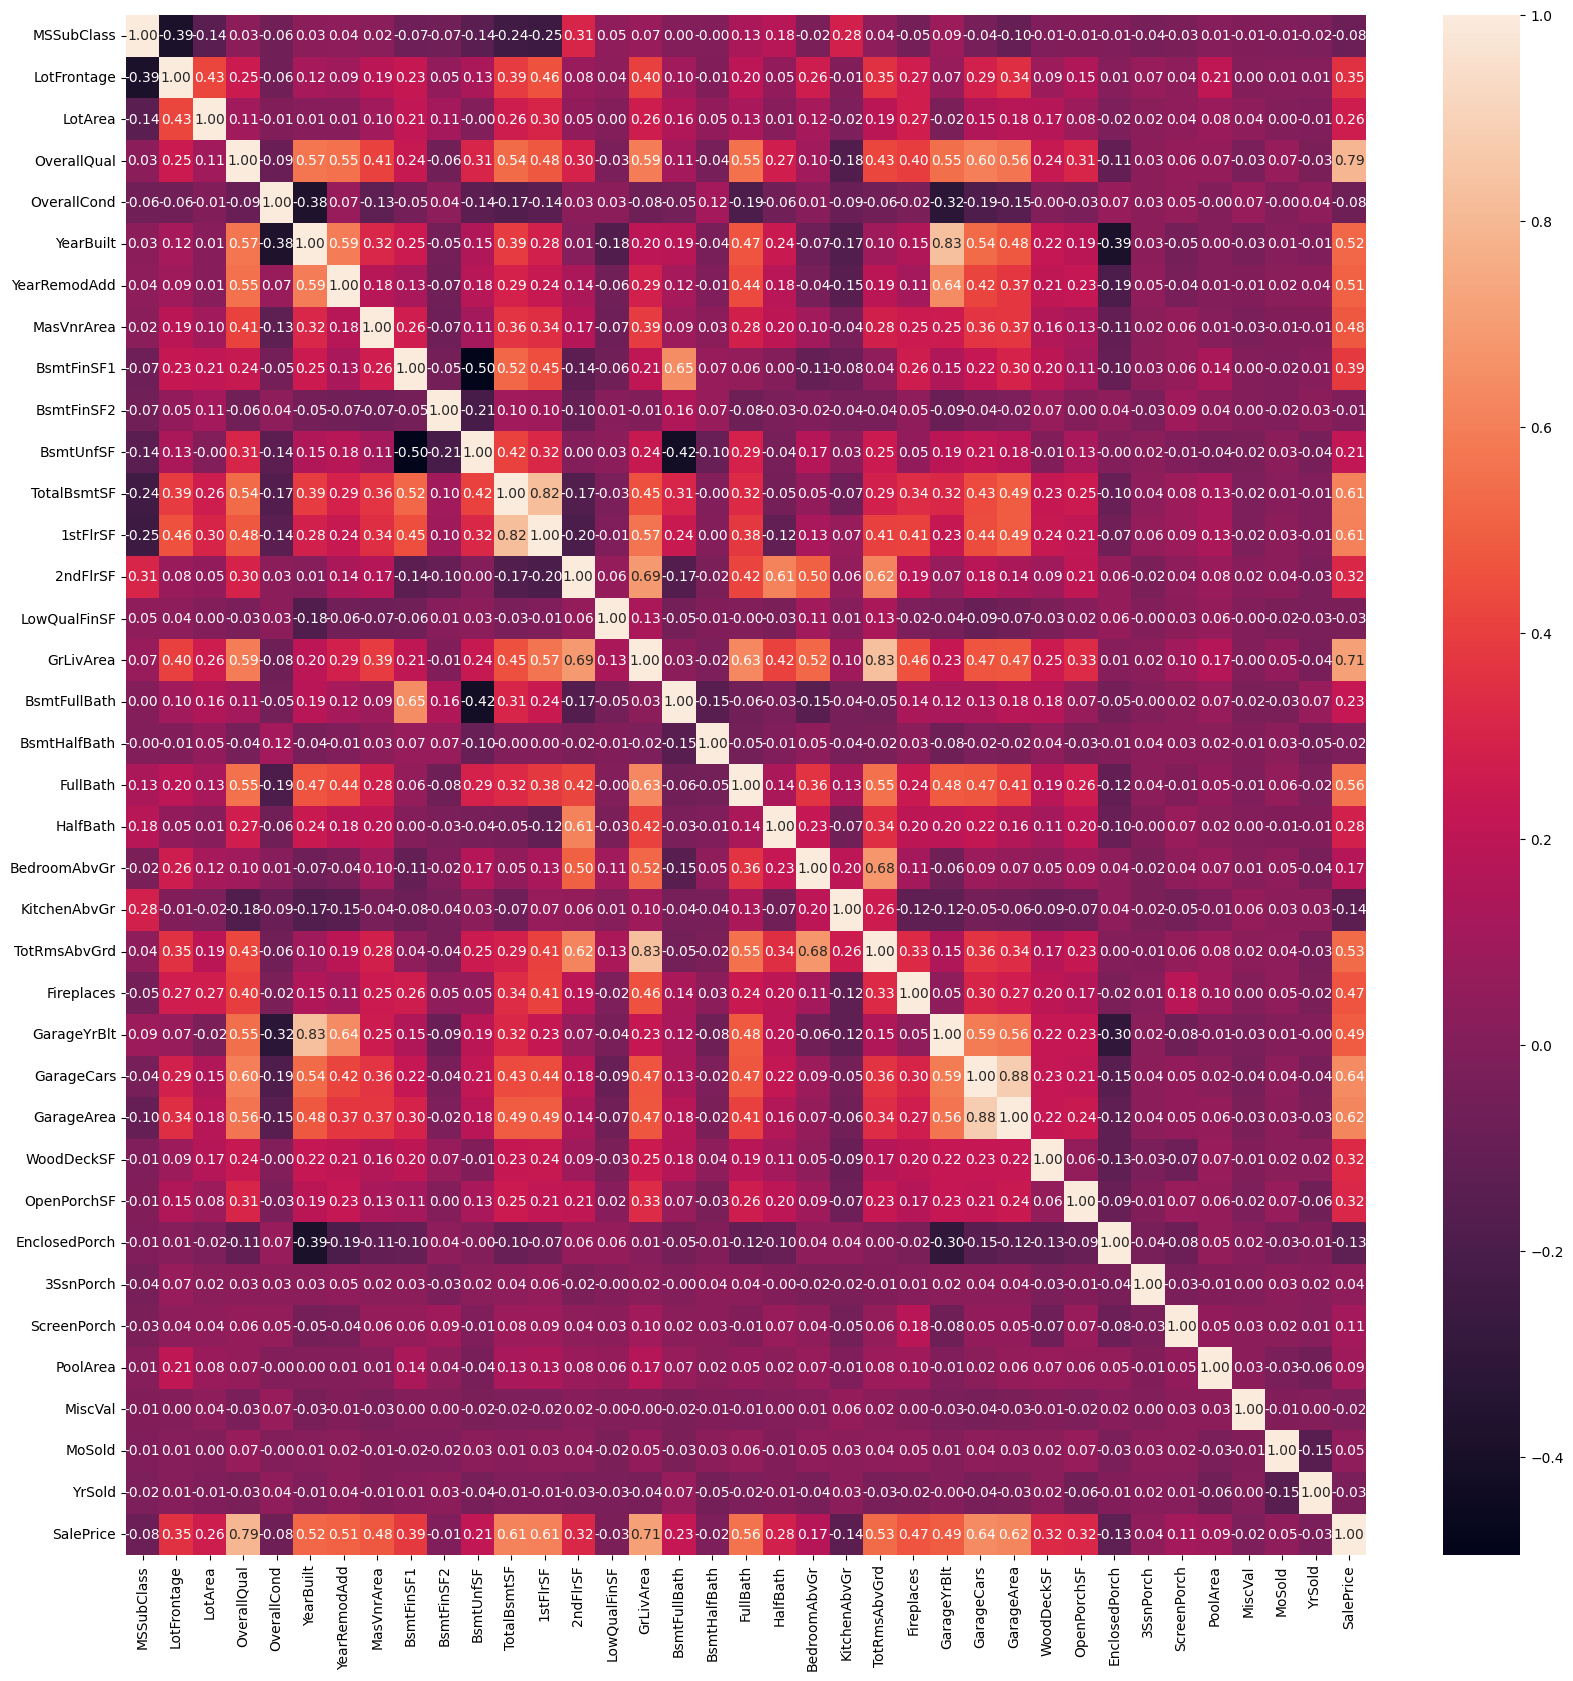

In [9]:
plt.figure(figsize= (20 , 20))
sns.heatmap(train.corr(), annot=True, fmt=".2f")
#observing this table, lets decide which variables are highly correlated.

In [42]:
#Seems that some variables are reduntant together: 
#Drop those with lower correlation to SalePrice:::::::

train.drop("TotRmsAbvGrd", axis = 1, inplace = True)
test.drop("TotRmsAbvGrd", axis = 1, inplace = True)
train.drop("GarageArea", axis = 1, inplace = True)
test.drop("GarageArea", axis = 1, inplace = True)
train.drop("1stFlrSF", axis = 1, inplace = True)
test.drop("1stFlrSF", axis = 1, inplace = True)
train.drop("GarageYrBlt", axis = 1, inplace = True)
test.drop("GarageYrBlt", axis = 1, inplace = True)

KeyError: "['TotRmsAbvGrd'] not found in axis"

In [12]:
train.shape, test.shape

((1460, 76), (1459, 75))

In [14]:
#Lets deal with missing values:
#Suppose we will not fill if the data missing exceeds 10% (indicating a potential issue with data)

total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

#We can drop all values from PoolQC to BsmtFinType1. Also, MasVnrArea and MasVnrType 
#can also be deleted due to high correlation with OverallQual. 
#Garage variables are quite interesting, with same number of missing values, and given 
#that  they are highly correlated, variable GarageCars is enough for the prediction. Similarly with Bsmt variables.
#for Electrical lets just delete the missing value house.

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479
GarageCond,81,0.055479


In [15]:
train = train.drop((missing_data[missing_data['Total'] > 1]).index,1)
train = train.drop(train.loc[train['Electrical'].isnull()].index)
test = test.drop((missing_data[missing_data['Total'] > 1]).index,1)

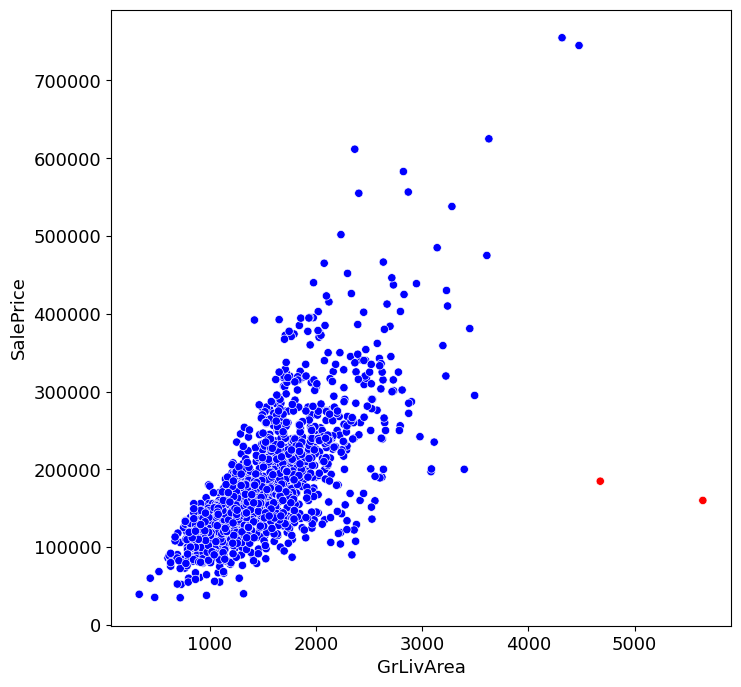

In [36]:
plot , ax = plt.subplots(figsize = (8 , 8))
outliers = (train["GrLivArea"] > 4600)
sns.scatterplot(data = train,x = "GrLivArea", y = "SalePrice", ax = ax, c = ["red" if is_outlier else "blue" for is_outlier in outliers])
plt.show()

<AxesSubplot: xlabel='OverallQual', ylabel='SalePrice'>

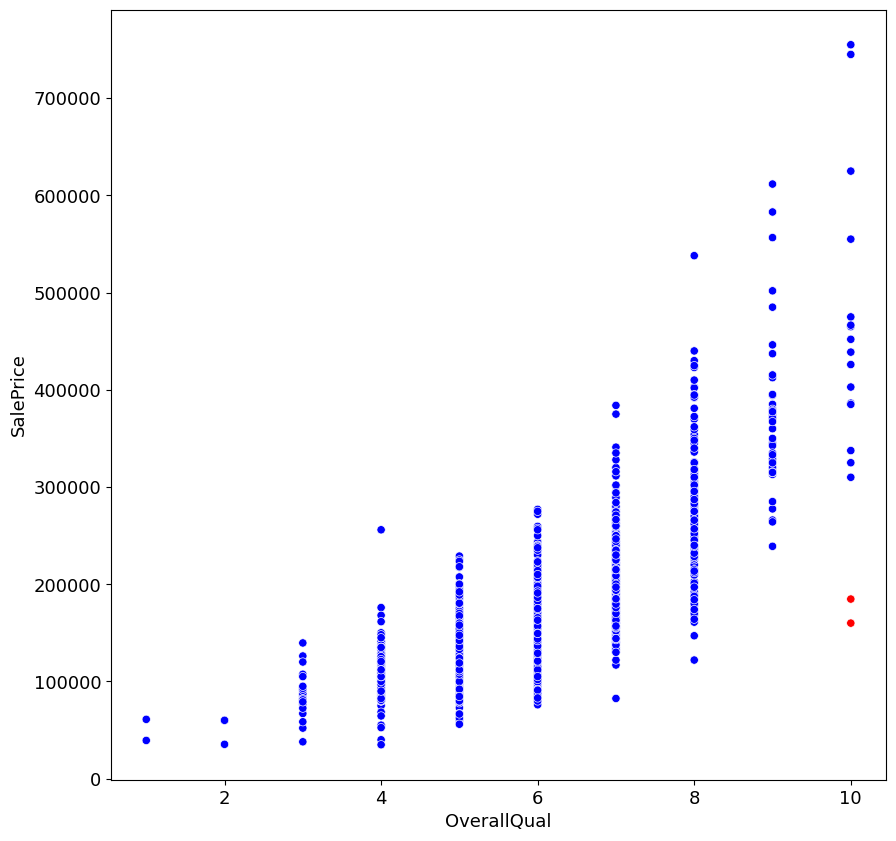

In [38]:
plot , ax = plt.subplots( figsize = (10, 10)), plt.rcParams.update({'font.size': 13})
outliers = (train["OverallQual"] == 10) & (train["SalePrice"] <= 250000)
sns.scatterplot(data = train ,x = "OverallQual", y = "SalePrice", c = ["red" if is_outlier else "blue" for is_outlier in outliers] )

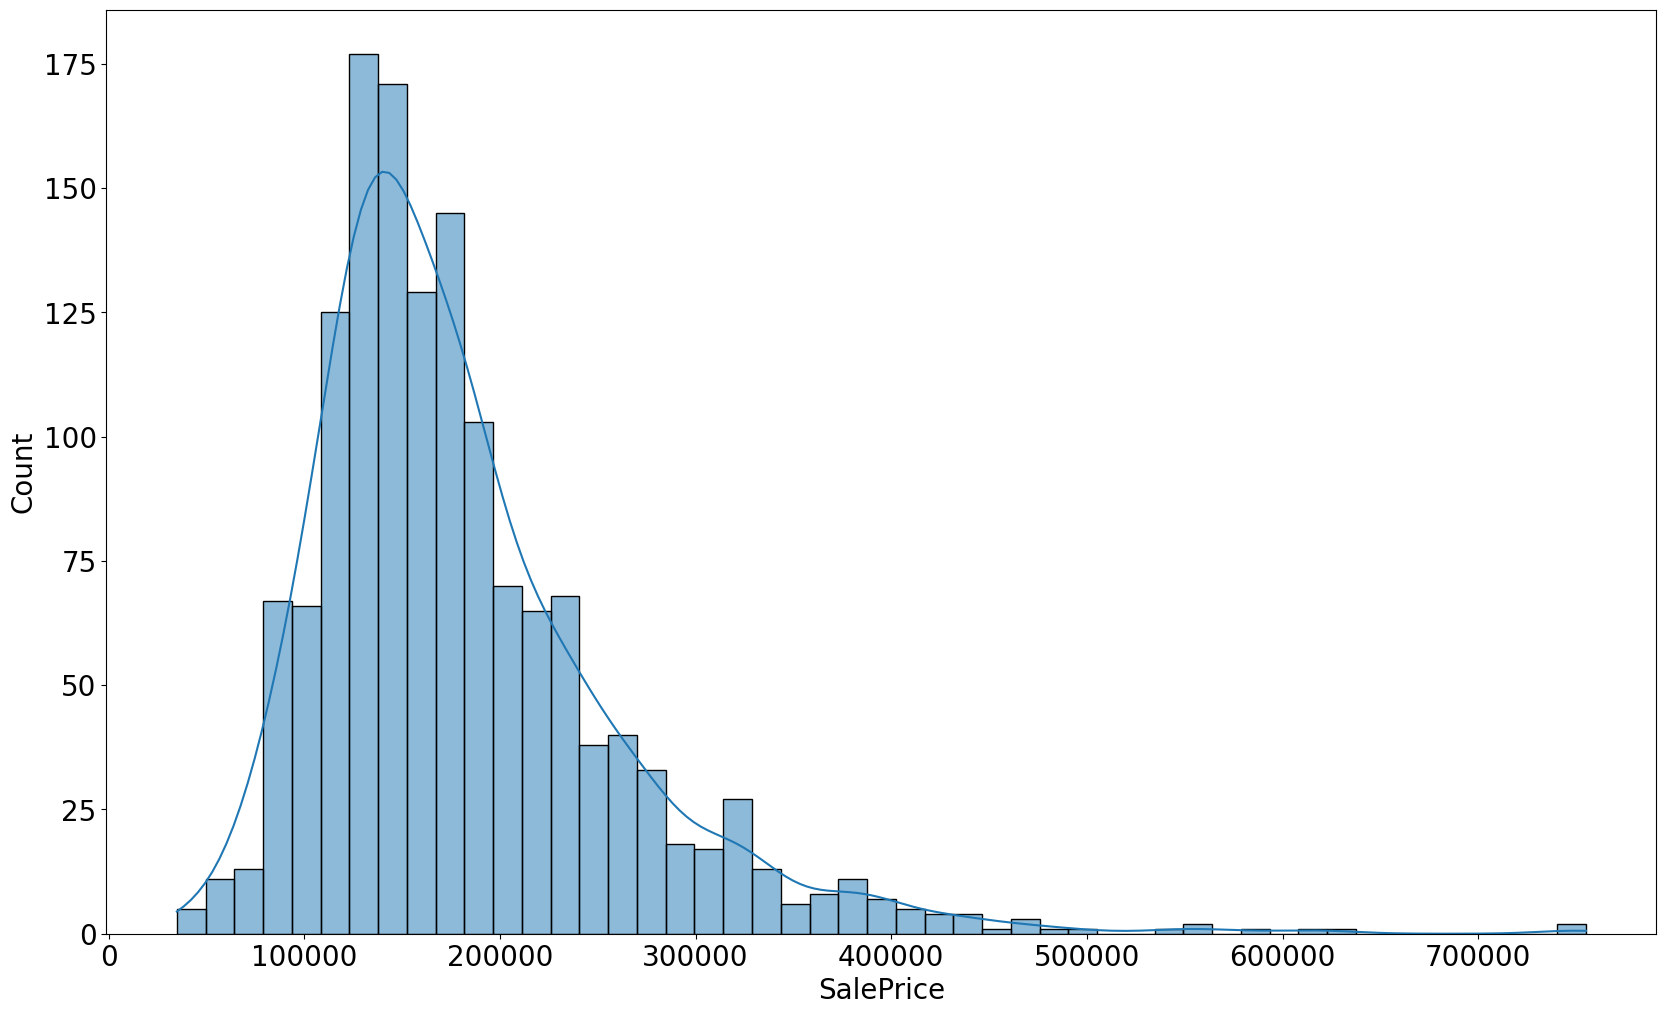

In [8]:
plt.figure(figsize= (20 , 12))
plt.rcParams.update({'font.size': 20})
g = sns.histplot(train.SalePrice , kde = True)

In [18]:
print('SalePrice Skewness is = ' , train.SalePrice.skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())
#salePrice is skewed. We will normalize it by taking log(x+1)

SalePrice Skewness is =  1.8819429948035529
Kurtosis: 6.529263


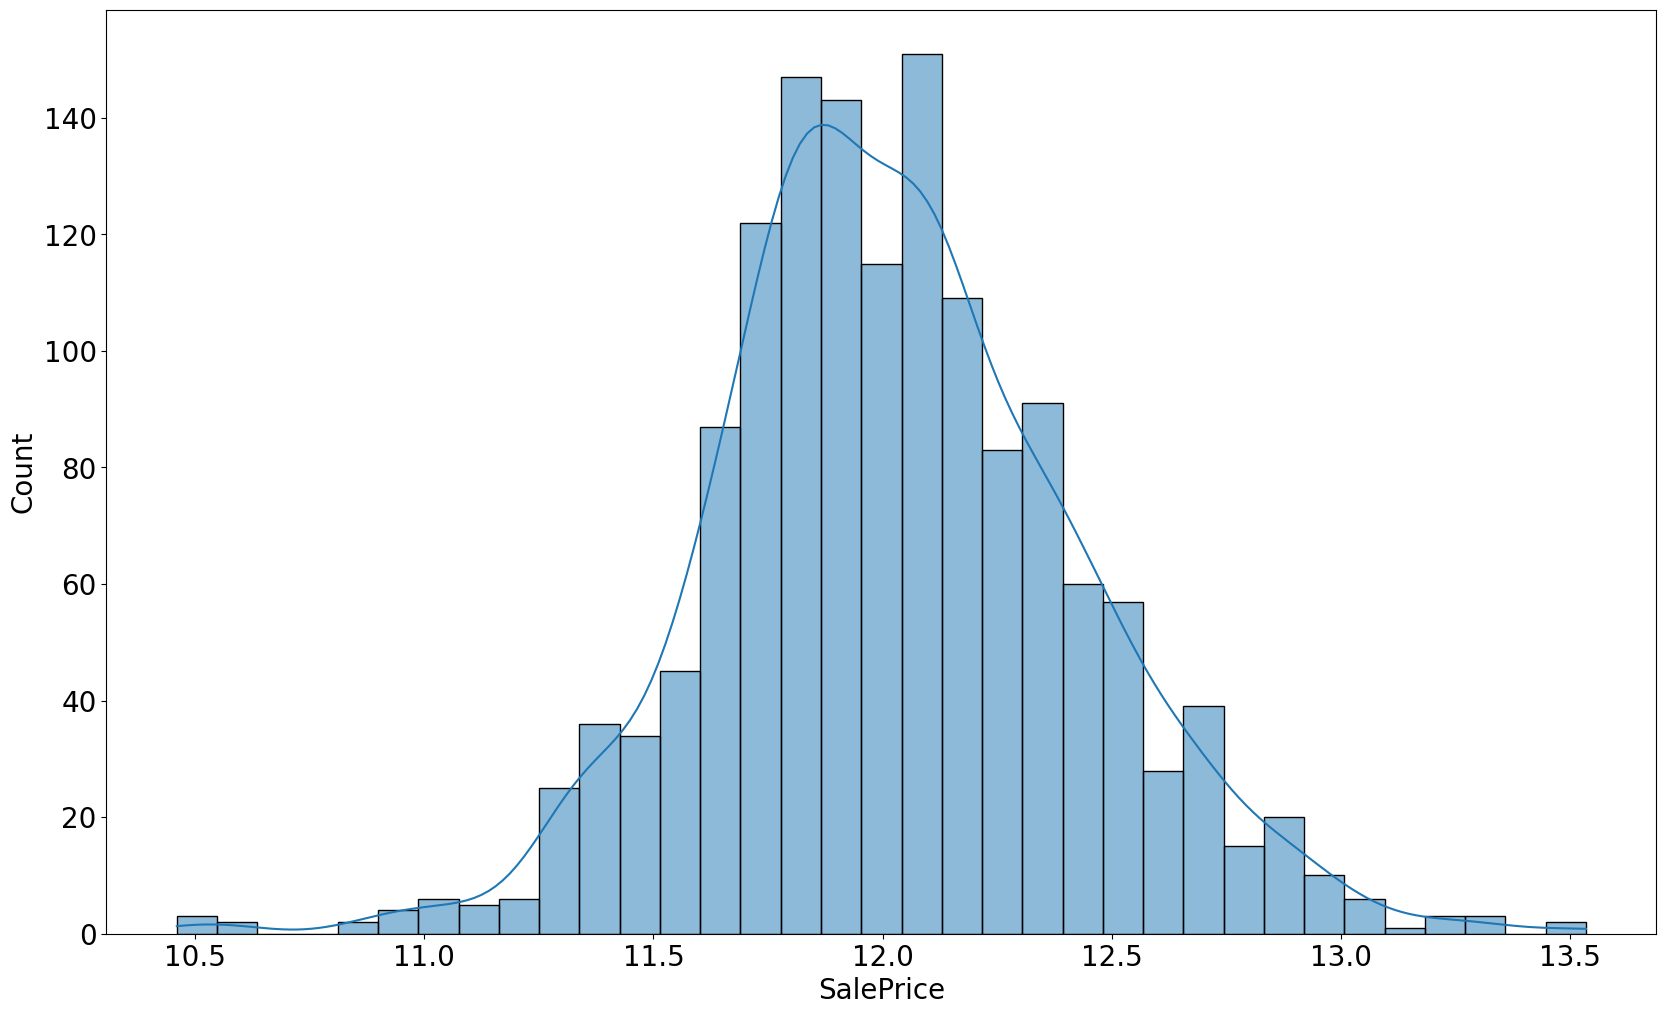

In [9]:
#Standartize SalePrice by taking log(x+1)
train["SalePrice"] = np.log1p(train["SalePrice"])
plt.figure(figsize= (20 , 12))
plt.rcParams.update({'font.size': 20})
g = sns.histplot(train.SalePrice , kde = True)

y = train["SalePrice"]
train = train.loc[:, train.columns != "SalePrice"]

In [20]:
total = test.isnull().sum().sort_values(ascending=False)
percent = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(15)

,Total,Percent
MSZoning,4,0.002742
Functional,2,0.001371
BsmtFullBath,2,0.001371
Utilities,2,0.001371
BsmtHalfBath,2,0.001371
BsmtFinSF1,1,0.000685
Exterior1st,1,0.000685
Exterior2nd,1,0.000685
GarageCars,1,0.000685
BsmtFinSF2,1,0.000685


In [21]:
#Lets fill remaining missing values in test with some intuitive or mode&median values:
test['MSZoning'] = test['MSZoning'].fillna(test['MSZoning'].mode()[0])
test['Functional'] = test['Functional'].fillna(test['Functional'].mode()[0])
test['Utilities'] = test['Utilities'].fillna(test['Utilities'].mode()[0])
test['Exterior1st'] = test['Exterior1st'].fillna(test['Exterior1st'].mode()[0])
test['Exterior2nd'] = test['Exterior2nd'].fillna(test['Exterior2nd'].mode()[0])
test['GarageCars'] = test['GarageCars'].fillna(test['GarageCars'].mode()[0])
test['KitchenQual'] = test['KitchenQual'].fillna("TA") 
test['BsmtFullBath'] = test['BsmtFullBath'].fillna(test['BsmtFullBath'].mode()[0])
test['BsmtHalfBath'] = test['BsmtHalfBath'].fillna(test['BsmtHalfBath'].mode()[0])
test['SaleType'] = test['SaleType'].fillna(test['SaleType'].mode()[0])
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(test['TotalBsmtSF'].mode()[0])
test['BsmtUnfSF'] = test['BsmtUnfSF'].fillna(test['BsmtUnfSF'].mode()[0])
test['BsmtFinSF2'] = test['BsmtFinSF2'].fillna(test['BsmtFinSF2'].mode()[0])
test['BsmtFinSF1'] = test['BsmtFinSF1'].fillna(test['BsmtFinSF1'].mode()[0])



In [22]:
train.shape, test.shape

((1459, 58), (1459, 58))

In [23]:
test.info(), train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 58 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1459 non-null   object 
 2   LotArea        1459 non-null   int64  
 3   Street         1459 non-null   object 
 4   LotShape       1459 non-null   object 
 5   LandContour    1459 non-null   object 
 6   Utilities      1459 non-null   object 
 7   LotConfig      1459 non-null   object 
 8   LandSlope      1459 non-null   object 
 9   Neighborhood   1459 non-null   object 
 10  Condition1     1459 non-null   object 
 11  Condition2     1459 non-null   object 
 12  BldgType       1459 non-null   object 
 13  HouseStyle     1459 non-null   object 
 14  OverallQual    1459 non-null   int64  
 15  OverallCond    1459 non-null   int64  
 16  YearBuilt      1459 non-null   int64  
 17  YearRemodAdd   1459 non-null   int64  
 18  RoofStyl

(None, None)

In [24]:
#Now lets transform some features so that the model can implement them

train['MSSubClass'] = train['MSSubClass'].apply(str)
train['YrSold'] = train['YrSold'].astype(str)
train['MoSold'] = train['MoSold'].astype(str)
test['MSSubClass'] = test['MSSubClass'].apply(str)
test['YrSold'] = test['YrSold'].astype(str)
test['MoSold'] = test['MoSold'].astype(str)



In [25]:
train_numeric = train.dtypes[train.dtypes != 'object'].index
test_numeric = test.dtypes[test.dtypes != 'object'].index

train_numeric_skewed = train[train_numeric].apply(lambda x: skew(x.dropna())) 
train_numeric_skewed = train_numeric_skewed[train_numeric_skewed > 0.75]
train_numeric_skewed = train_numeric_skewed.index

test_numeric_skewed = test[test_numeric].apply(lambda x: skew(x.dropna())) 
test_numeric_skewed = test_numeric_skewed[test_numeric_skewed > 0.75]
test_numeric_skewed = test_numeric_skewed.index

train[train_numeric_skewed] = np.log1p(train[train_numeric_skewed])
test[test_numeric_skewed] = np.log1p(test[test_numeric_skewed])


In [26]:
test.info(), train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 58 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   object 
 1   MSZoning       1459 non-null   object 
 2   LotArea        1459 non-null   float64
 3   Street         1459 non-null   object 
 4   LotShape       1459 non-null   object 
 5   LandContour    1459 non-null   object 
 6   Utilities      1459 non-null   object 
 7   LotConfig      1459 non-null   object 
 8   LandSlope      1459 non-null   object 
 9   Neighborhood   1459 non-null   object 
 10  Condition1     1459 non-null   object 
 11  Condition2     1459 non-null   object 
 12  BldgType       1459 non-null   object 
 13  HouseStyle     1459 non-null   object 
 14  OverallQual    1459 non-null   int64  
 15  OverallCond    1459 non-null   int64  
 16  YearBuilt      1459 non-null   int64  
 17  YearRemodAdd   1459 non-null   int64  
 18  RoofStyl

(None, None)

In [27]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score


In [28]:
all_data = pd.concat([train, test]).reset_index(drop=True)

all_data = pd.get_dummies(all_data).reset_index(drop=True)

In [29]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2918 entries, 0 to 2917
Columns: 247 entries, LotArea to SaleCondition_Partial
dtypes: float64(20), int64(7), uint8(220)
memory usage: 1.2 MB


In [30]:
X_train = all_data.iloc[:len(y),:]
X_test = all_data.iloc[len(y):,:]


In [31]:
X_train.shape, y.shape, X_test.shape

((1459, 247), (1459,), (1459, 247))

In [32]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X_train):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)



In [33]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [34]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))

In [35]:
ridge_scores = cv_rmse(ridge)

In [36]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [37]:
lasso_scores = cv_rmse(model_lasso)

In [38]:
ridge_scores.min(),ridge_scores.std(),  lasso_scores.min(), lasso_scores.std(), 

(0.0868728655112285,
 0.02888248698567506,
 0.08640942393146804,
 0.029990167304468726)

In [39]:
lasso_preds = np.expm1(model_lasso.predict(X_test))
lasso_preds 

array([119358.15971978, 154850.10978087, 179660.97172054, ...,
       169013.47182968, 118279.86624174, 230272.47366966])

In [40]:
t = pd.read_csv('test.csv')

In [41]:
submission = pd.DataFrame({'Id': t.Id, 'SalePrice': lasso_preds})
submission.to_csv("submission-lasso.csv", index=False)